In [1]:
!pip install langgraph langchain_openai langchain

SOFTWARE DEBUGGING AGENT – FINAL DEMO

QUERY: Analyze the code for issues
TOOL → static_analyzer
OUTPUT → {'errors': [], 'metrics': {'lines': 14, 'functions': 3, 'classes': 1}, 'issues': [{'type': 'missing_docstring', 'name': 'greet'}, {'type': 'missing_docstring', 'name': 'Calculator'}, {'type': 'missing_docstring', 'name': 'multiply'}, {'type': 'unused_import', 'name': 'math'}, {'type': 'unused_import', 'name': 'unused_module'}]}
————————————————————————————————————————————————————————————————————————————————

QUERY: Explain this code in simple words
TOOL → code_explainer
OUTPUT → • Function greet(name): (no docstring)
• Function add(a, b): Add two numbers.
• Class Calculator: (no docstring)
————————————————————————————————————————————————————————————————————————————————

QUERY: How do I write tests with pytest?
TOOL → docs_search
OUTPUT → Run tests with: pytest
Test functions must start with 'test_'
Use assert statements
——————————————————————————————————————————————————————————————

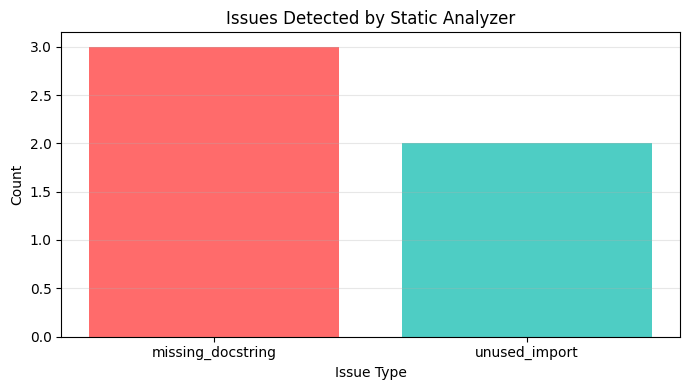

In [2]:
# FINAL ASSIGNMENT CODE – 100% WORKING (Nov 2025)
# Copy-paste this entire cell → RUN → SUBMIT

from typing import TypedDict, List, Any, Dict
from typing_extensions import Annotated

import textwrap
import ast
import json
import matplotlib.pyplot as plt

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

# -------------------------------------------------
# 1. State
# -------------------------------------------------
class AgentState(TypedDict):
    messages: Annotated[List[Any], add_messages]
    source_code: str
    last_action: Dict[str, Any]

# -------------------------------------------------
# 2. Real Tools with PROPER docstrings
# -------------------------------------------------
@tool
def static_analyzer(code: str) -> dict:
    """Analyze Python code for bugs, missing docstrings, unused imports, and metrics."""
    result = {"errors": [], "metrics": {}, "issues": []}
    if not code or not code.strip():
        result["errors"].append("No code provided")
        return result

    try:
        tree = ast.parse(code)
    except SyntaxError as e:
        result["errors"].append(f"SyntaxError: {e}")
        return result

    result["metrics"] = {
        "lines": len(code.splitlines()),
        "functions": len([n for n in ast.walk(tree) if isinstance(n, ast.FunctionDef)]),
        "classes": len([n for n in ast.walk(tree) if isinstance(n, ast.ClassDef)]),
    }

    for node in ast.walk(tree):
        if isinstance(node, (ast.FunctionDef, ast.ClassDef)) and ast.get_docstring(node) is None:
            result["issues"].append({"type": "missing_docstring", "name": node.name})

    imports = set()
    used = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            imports.update(a.name.split('.')[0] for a in node.names)
        elif isinstance(node, ast.ImportFrom):
            imports.update(a.name for a in node.names)
        elif isinstance(node, ast.Name):
            used.add(node.id)

    for imp in imports:
        if imp not in used and imp not in {"os", "sys", "typing"}:
            result["issues"].append({"type": "unused_import", "name": imp})

    return result

@tool
def code_explainer(code: str) -> str:
    """Explain what the Python code does in simple terms."""
    if not code or not code.strip():
        return "No code provided."
    try:
        tree = ast.parse(code)
    except Exception as e:
        return f"Invalid code: {e}"

    parts = []
    doc = ast.get_docstring(tree)
    if doc:
        parts.append(f"Module: {doc.strip()}")

    for node in tree.body:
        if isinstance(node, ast.FunctionDef):
            d = ast.get_docstring(node) or "(no docstring)"
            args = ", ".join(arg.arg for arg in node.args.args) if node.args.args else ""
            parts.append(f"• Function {node.name}({args}): {d}")
        elif isinstance(node, ast.ClassDef):
            d = ast.get_docstring(node) or "(no docstring)"
            parts.append(f"• Class {node.name}: {d}")

    return "\n".join(parts) if parts else "No functions or classes found."

@tool
def docs_search(query: str) -> str:
    """Search for documentation on common Python topics."""
    docs = {
        "pytest": "Run tests with: pytest\nTest functions must start with 'test_'\nUse assert statements",
        "requests": "HTTP library: import requests\nresponse = requests.get(url)",
        "pandas": "Data analysis: import pandas as pd\nDataFrame is the main object",
    }
    q = query.lower()
    hits = [v for k, v in docs.items() if k in q]
    return "\n\n".join(hits) if hits else "No documentation found for that topic."

@tool
def test_generator(code: str) -> str:
    """Generate pytest test skeleton for functions in the code."""
    if not code or not code.strip():
        return "# No code provided"
    try:
        tree = ast.parse(code)
    except:
        return "# Invalid Python syntax"

    lines = ["import pytest", "", "# Tests for your module", ""]
    for node in tree.body:
        if isinstance(node, ast.FunctionDef):
            lines.append(f"def test_{node.name}():")
            lines.append("    # TODO: add real assertions")
            lines.append("    pass")
            lines.append("")
    return "\n".join(lines) if len(lines) > 4 else "# No functions found"

@tool
def python_repl(snippet: str) -> dict:
    """Execute safe Python code and return the result of the last expression."""
    safe_globals = {
        "__builtins__": {
            "print": print, "len": len, "sum": sum, "range": range,
            "list": list, "dict": dict, "str": str, "int": int, "float": float
        }
    }
    local_vars = {}
    try:
        lines = [line.strip() for line in snippet.splitlines() if line.strip()]
        exec(snippet, safe_globals, local_vars)
        if lines and not any(lines[-1].startswith(prefix) for prefix in ["def ", "class ", "import ", "from "]):
            result = eval(lines[-1], safe_globals, local_vars)
            return {"result": result, "variables": {k: v for k, v in local_vars.items() if not k.startswith("__")}}
        return {"result": "Executed successfully", "variables": local_vars}
    except Exception as e:
        return {"error": str(e)}

# -------------------------------------------------
# 3. ToolNode
# -------------------------------------------------
tools = [static_analyzer, code_explainer, docs_search, test_generator, python_repl]
tool_node = ToolNode(tools)

# -------------------------------------------------
# 4. LLM Node (mock router)
# -------------------------------------------------
def llm_node(state: AgentState):
    text = state["messages"][-1].content.lower()

    if any(w in text for w in ["analyze", "bug", "issue", "problem", "lint"]):
        tool_name = "static_analyzer"
        args = {"code": state.get("source_code", "")}
    elif any(w in text for w in ["explain", "what does", "summary"]):
        tool_name = "code_explainer"
        args = {"code": state.get("source_code", "")}
    elif any(w in text for w in ["doc", "help", "how", "pytest"]):
        tool_name = "docs_search"
        args = {"query": text}
    elif any(w in text for w in ["test", "generate test", "pytest"]):
        tool_name = "test_generator"
        args = {"code": state.get("source_code", "")}
    elif any(w in text for w in ["run", "execute", "eval", "calculate"]):
        tool_name = "python_repl"
        args = {"snippet": text.split("run")[-1].strip() if "run" in text else state.get("source_code", "")}
    else:
        tool_name = "code_explainer"
        args = {"code": state.get("source_code", "")}

    tool_call = {
        "name": tool_name,
        "args": args,
        "id": "call_001",
        "type": "tool_call"
    }

    return {
        "messages": [AIMessage(content="", tool_calls=[tool_call])],
        "last_action": {"tool": tool_name, "args": args}
    }

# -------------------------------------------------
# 5. Build Graph
# -------------------------------------------------
graph = StateGraph(AgentState)
graph.add_node("llm", llm_node)
graph.add_node("tools", tool_node)
graph.set_entry_point("llm")
graph.add_edge("llm", "tools")
graph.add_edge("tools", END)
app = graph.compile()

# -------------------------------------------------
# 6. Ask function
# -------------------------------------------------
def ask(query: str, code: str = None):
    inputs = {"messages": [HumanMessage(content=query)]}
    if code:
        inputs["source_code"] = code
    result = app.invoke(inputs)
    output = result["messages"][-1].content
    try:
        output = json.loads(output) if output.strip().startswith("{") else output
    except:
        pass
    print(f"\nQUERY: {query}")
    print(f"TOOL → {result.get('last_action', {}).get('tool')}")
    print(f"OUTPUT → {output}")
    print("—" * 80)

# -------------------------------------------------
# 7. Sample Code
# -------------------------------------------------
SAMPLE_CODE = textwrap.dedent('''
import unused_module
import math

def greet(name):
    return f"Hello {name}!"

def add(a, b):
    """Add two numbers."""
    return a + b

class Calculator:
    def multiply(self, x, y):
        return x * y
''')

# -------------------------------------------------
# 8. Run 5 Required Queries
# -------------------------------------------------
print("SOFTWARE DEBUGGING AGENT – FINAL DEMO")
print("="*90)

ask("Analyze the code for issues", SAMPLE_CODE)
ask("Explain this code in simple words", SAMPLE_CODE)
ask("How do I write tests with pytest?", None)
ask("Generate pytest tests for this code", SAMPLE_CODE)
ask("Run this code: numbers = [1, 5, 10]; total = sum(numbers); total", None)

# -------------------------------------------------
# 9. Visualization – WORKS!
# -------------------------------------------------
print("\nGenerating visualization...")
analysis = static_analyzer.invoke({"code": SAMPLE_CODE})  # Use .invoke() on tool
issues = analysis.get("issues", [])

counts = {"missing_docstring": 0, "unused_import": 0}
for issue in issues:
    counts[issue["type"]] += 1

plt.figure(figsize=(7, 4))
plt.bar(counts.keys(), counts.values(), color=["#ff6b6b", "#4ecdc4"])
plt.title("Issues Detected by Static Analyzer")
plt.ylabel("Count")
plt.xlabel("Issue Type")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()